Gabor ML - Problem 16

-Clarice Mottet

Outline:
-generate training data
    -x_i multivariate normal distribution (mean zero, covariance diagonal (1/1...d))
    -y_i sum(x_i) + e_i where e_i standard normal random variable
-measure performance by mean squared error R(w) = E(wTX-Y)^2
-write program that learns vector w by OLS
-write program that learns vector w by GD
-write program that learns vector w by SGD
-compare performance by mean squared error and running time for multiple n and d and step size n_t

In [1]:
#libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time

path_out_ = r'/home/clarice/Documents/VSCode/Term2_Gabor_ML/homework4/GaborML_problem16/outputs'
random.seed(123)

In [2]:
#functions

def generate_data(n, d):

    #covariance matrix
    cov = np.identity(d)    
    for i in range(d):
        cov[i,i] = 1/(i+1)

    #x
    x = np.random.multivariate_normal(np.zeros(d), cov, n)

    #y
    y = np.zeros(n)
    e = np.random.normal(0, 1, n)
    for i in range(n):
        y[i] = sum(x[i]) + e[i]

    return x, y

def solve_OLS(x, y):
    n = len(x)
    d = len(x[0])

    matrix_xx = np.zeros((d,d))
    for i in range(n):
        add_matrix = np.outer(x[i], x[i].T)
        matrix_xx = np.add(matrix_xx, add_matrix)
    matrix_xx = np.multiply(1/n, matrix_xx)
    matrix_xx = np.linalg.inv(matrix_xx)

    vec_xy = np.zeros(d)
    for i in range(n):
        add_vec = np.multiply(x[i], y[i])
        vec_xy = np.add(vec_xy, add_vec)
    vec_xy = np.multiply(1/n, vec_xy)

    w = np.dot(matrix_xx, vec_xy)
    return w

def solve_GD(x, y, step_size_type):
    """
    step_size_type have value "static" or "desc"
    """
    #initializing sizes
    n = len(x)
    d = len(x[0])
    num_epochs = n

    #step size types
    if step_size_type == "static":
        n_step = [.1 for i in range(num_epochs)]
    elif step_size_type == "desc":
        n_step = [1/np.sqrt(i+1) for i in range(num_epochs)]
    else:
        print("error with step_size_type input, 'assuming static'")
        n_step = [.1 for i in range(num_epochs)]

    #blank w matrix to hold w vector values
    w = np.zeros((num_epochs+1,d))

    #run through algorithm
    for t in range(1,num_epochs+1):
        vec_sum = np.zeros(d)
        for i in range(n):
            vec_lhs = np.multiply(np.dot(w[t-1].T,x[i]),x[i])
            vec_rhs = np.multiply(x[i], y[i])
            vec_sum = np.add(vec_sum, np.subtract(vec_lhs, vec_rhs))
        vec_sum = np.multiply(2/n,vec_sum)
        vec_sum = np.multiply(n_step[t-1],vec_sum)
        w[t] = np.subtract(w[t-1], vec_sum)

    #calculate average of weights
    w_avg = np.zeros(d)
    for t in range(1, num_epochs+1):
        w_avg = np.add(w_avg, w[t])
    w_avg = np.multiply(1/num_epochs, w_avg)
    return w_avg

#used in SGD algorithm
def shuffle_data(x, y):

    n = len(x)
    d = len(x[0])

    indexes = [i for i in range(n)]
    shuffle_index = sorted(indexes, key = lambda x: random.random())

    x_shuffle = np.zeros((n,d))
    y_shuffle = np.zeros(n)

    for i in range(n):
        x_shuffle[i] = x[shuffle_index[i]]
        y_shuffle[i] = y[shuffle_index[i]]

    return x_shuffle, y_shuffle

def solve_SGD(x_input, y_input, step_size_type):
    """
    step_size_type have value "static" or "desc"
    """

    #shuffle the data to ensure that it converges regardless of order of data points
    x, y = shuffle_data(x_input, y_input)

    #initializing sizes
    n = len(x)
    d = len(x[0])
    num_epochs = n

    #step size types
    if step_size_type == "static":
        n_step = [.1 for i in range(num_epochs)]
    elif step_size_type == "desc":
        n_step = [1/np.sqrt(i+1) for i in range(num_epochs)]
    else:
        print("error with step_size_type input, 'assuming static'")
        n_step = [.1 for i in range(num_epochs)]

    #blank w matrix to hold w vector values
    w = np.zeros((num_epochs+1,d))

    #run through algorithm
    for t in range(1,num_epochs+1):
        vec_lhs = np.multiply(np.dot(w[t-1].T,x[t-1]),x[t-1])
        vec_rhs = np.multiply(x[t-1], y[t-1])
        vec_ = np.subtract(vec_lhs, vec_rhs)
        vec_ = np.multiply(2,vec_)
        vec_ = np.multiply(n_step[t-1],vec_)
        w[t] = np.subtract(w[t-1], vec_)

    #calculate average of weights
    w_avg = np.zeros(d)
    for t in range(1, num_epochs+1):
        w_avg = np.add(w_avg, w[t])
    w_avg = np.multiply(1/num_epochs, w_avg)
    return w_avg

def calc_mse(x, y, w):
    n = len(x)
    mse = 0
    for i in range(n):
        mse += np.square(np.dot(w.T,x[i])-y[i])
    mse = mse/n
    return mse


In [5]:
#keep track of outputs
df_log = pd.DataFrame()

In [7]:
# #create a log of the simulations with various n values and d values

# n_values = [50, 100, 500, 750, 1000]
# d_values = [10, 250, 500, 1000]
# step_values = ["static", "desc"]
# method_values = ['OLS','GD','SGD']

# num_of_simulations = 10

# for iter_ in range(num_of_simulations):
#     print(iter_)
#     for n in n_values:
#         for d in d_values:
#             x_train, y_train = generate_data(n, d)
#             x_test, y_test = generate_data(n, d)
#             for step_size_type in step_values:
#                 for method in method_values:
#                     start_time = time.time()
#                     if method == 'OLS':
#                         w = solve_OLS(x_train, y_train)
#                     elif method == 'GD':
#                         w = solve_GD(x_train, y_train, step_size_type)
#                     else:
#                         w = solve_SGD(x_train, y_train, step_size_type)
#                     end_time = time.time()
#                     time_method = (end_time - start_time)
#                     mse_train = calc_mse(x_train, y_train, w)
#                     mse_test = calc_mse(x_test, y_test, w)
#                     df_ = pd.DataFrame([[iter_, method, step_size_type, n, d, time_method, mse_train, mse_test]], columns = ['simulation_run','method','step_size_type','n_value','d_value','run_time','mse_train','mse_test'])
#                     df_log = pd.concat([df_log, df_], ignore_index = True)
#                     df_log.reset_index(drop = True, inplace = True)
#                     df_log.to_excel(path_out_+'//'+'df_log_smallern.xlsx',index = False)


In [ ]:
#reimport in df_log

df_log = pd.read_excel(path_out_+'//'+'df_log_smallern.xlsx')


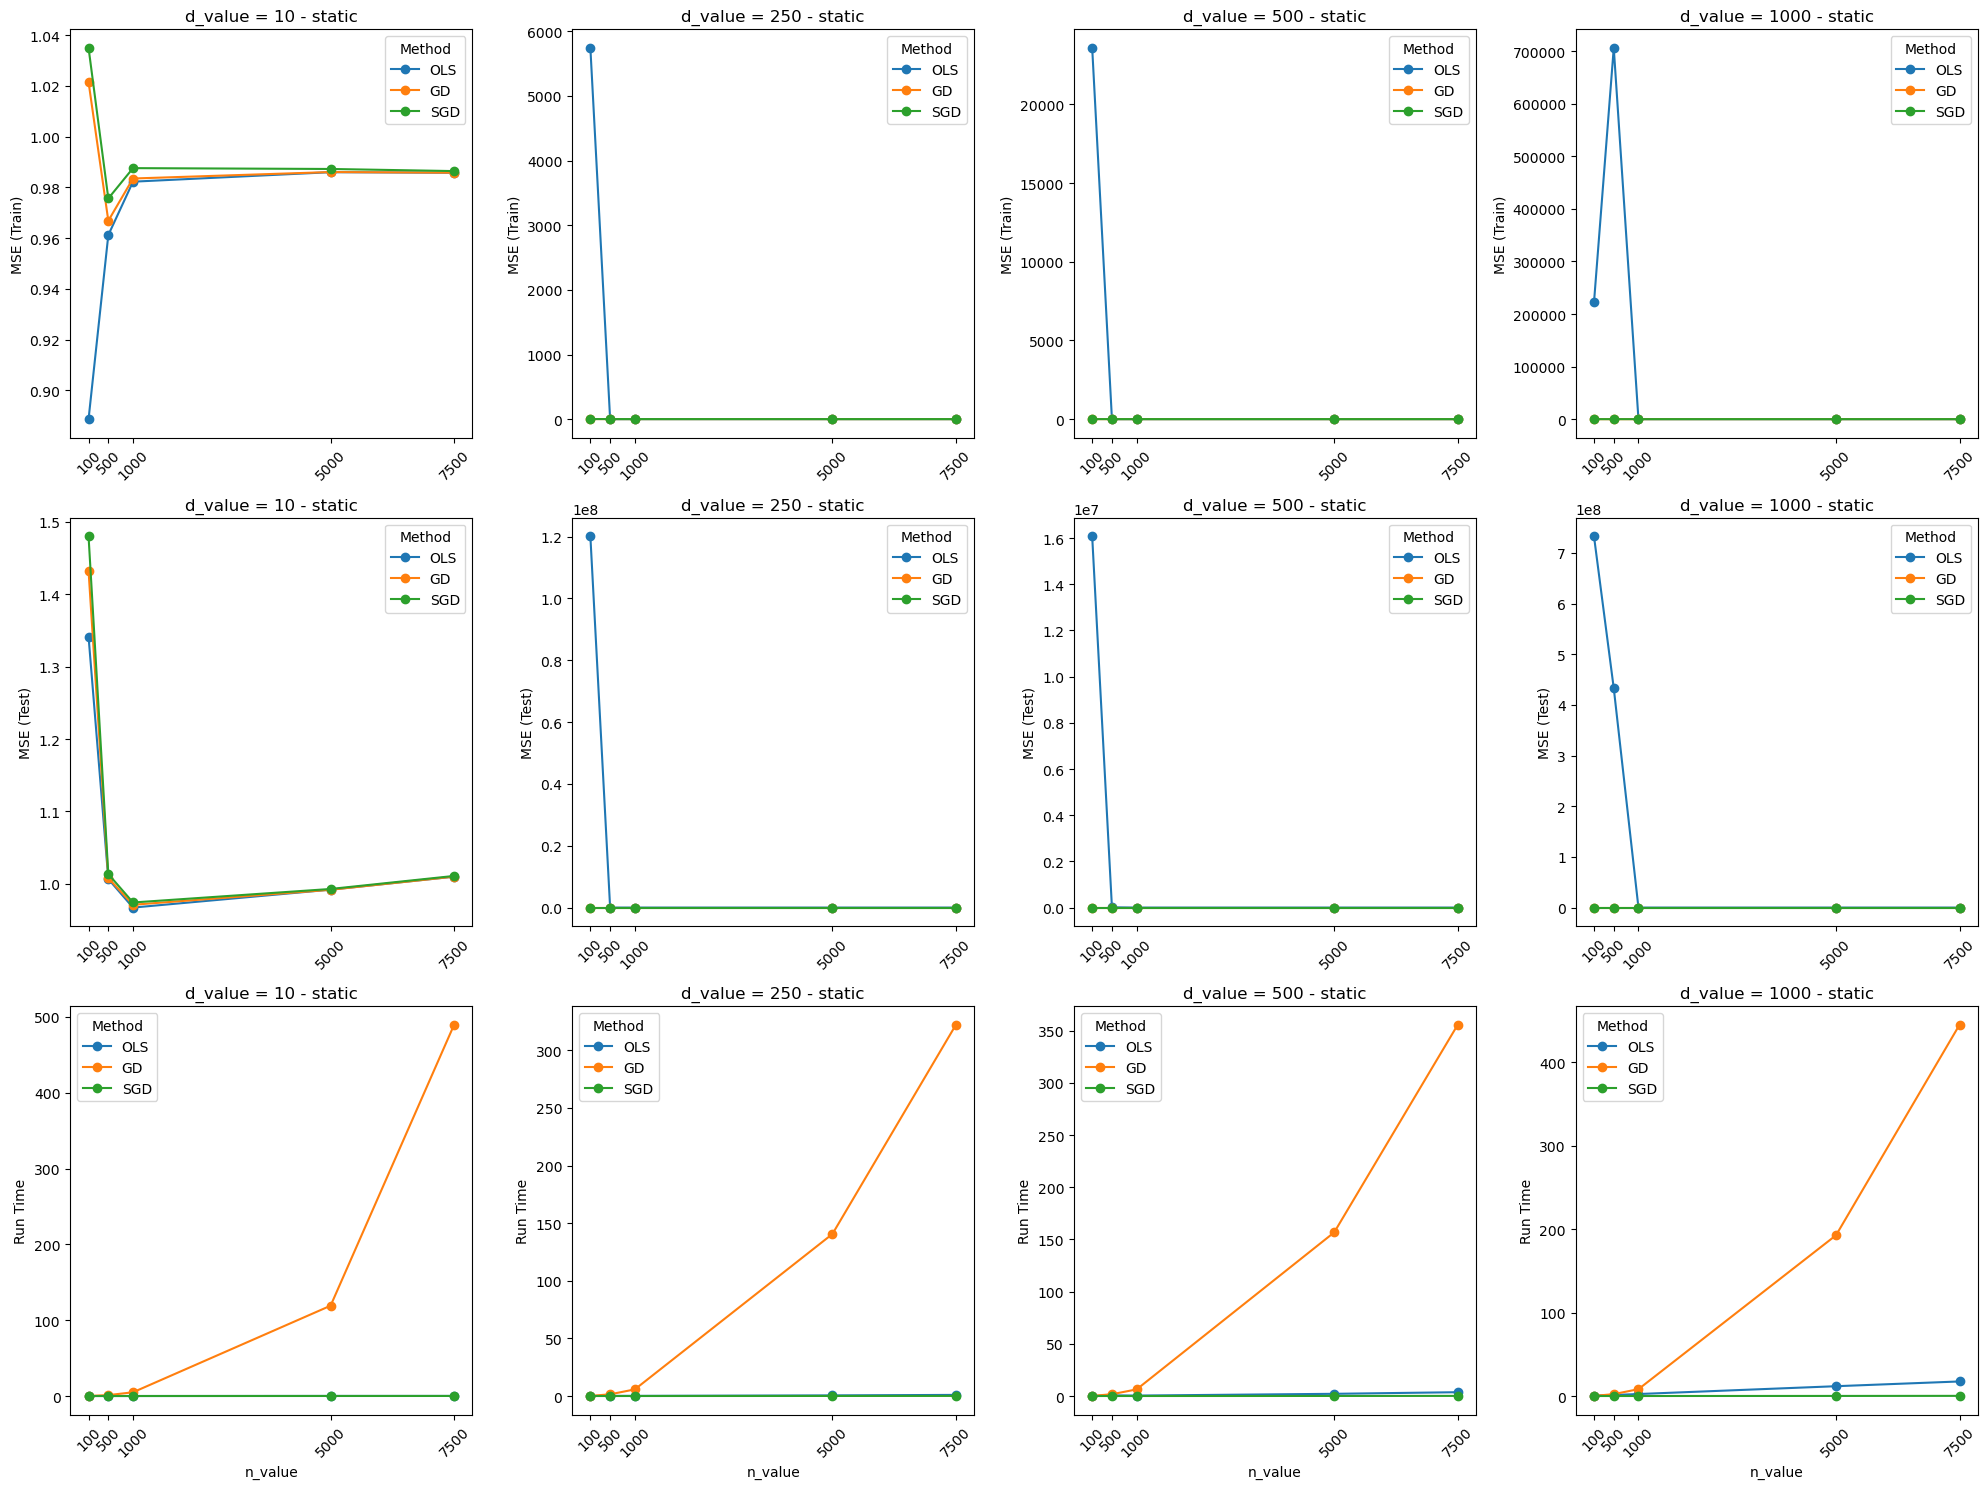

In [ ]:
#plot results

step_size_type = "static"

df_log_ = df_log[df_log['step_size_type']==step_size_type].copy()
df_log_.reset_index(drop = True, inplace = True)

col_avg_values = ['mse_train','mse_test','run_time']
for col in col_avg_values:
    df_log_[col] = df_log_.groupby(by = ['method','n_value','d_value'])[col].transform('mean')

df_log_.drop_duplicates(subset = ['method','n_value','d_value'], inplace = True)
methods = ['OLS', 'GD', 'SGD']
df = df_log_.copy()

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    for j, d_val in enumerate(d_values):
        ax = axes[i, j]
        for method in methods:
            subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
            ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
        
        ax.set_title(f'd_value = {d_val} - {step_size_type}')
        if i == 0:
            ax.set_ylabel('MSE (Train)')
        elif i == 1:
            ax.set_ylabel('MSE (Test)')
        else:
            ax.set_ylabel('Run Time')
        ax.legend(title='Method')
        ax.set_xticks(subset['n_value'])
        ax.tick_params(axis='x', rotation=45)

for ax in axes[-1, :]:
    ax.set_xlabel('n_value')

plt.tight_layout()
plt.show()


add commentary here

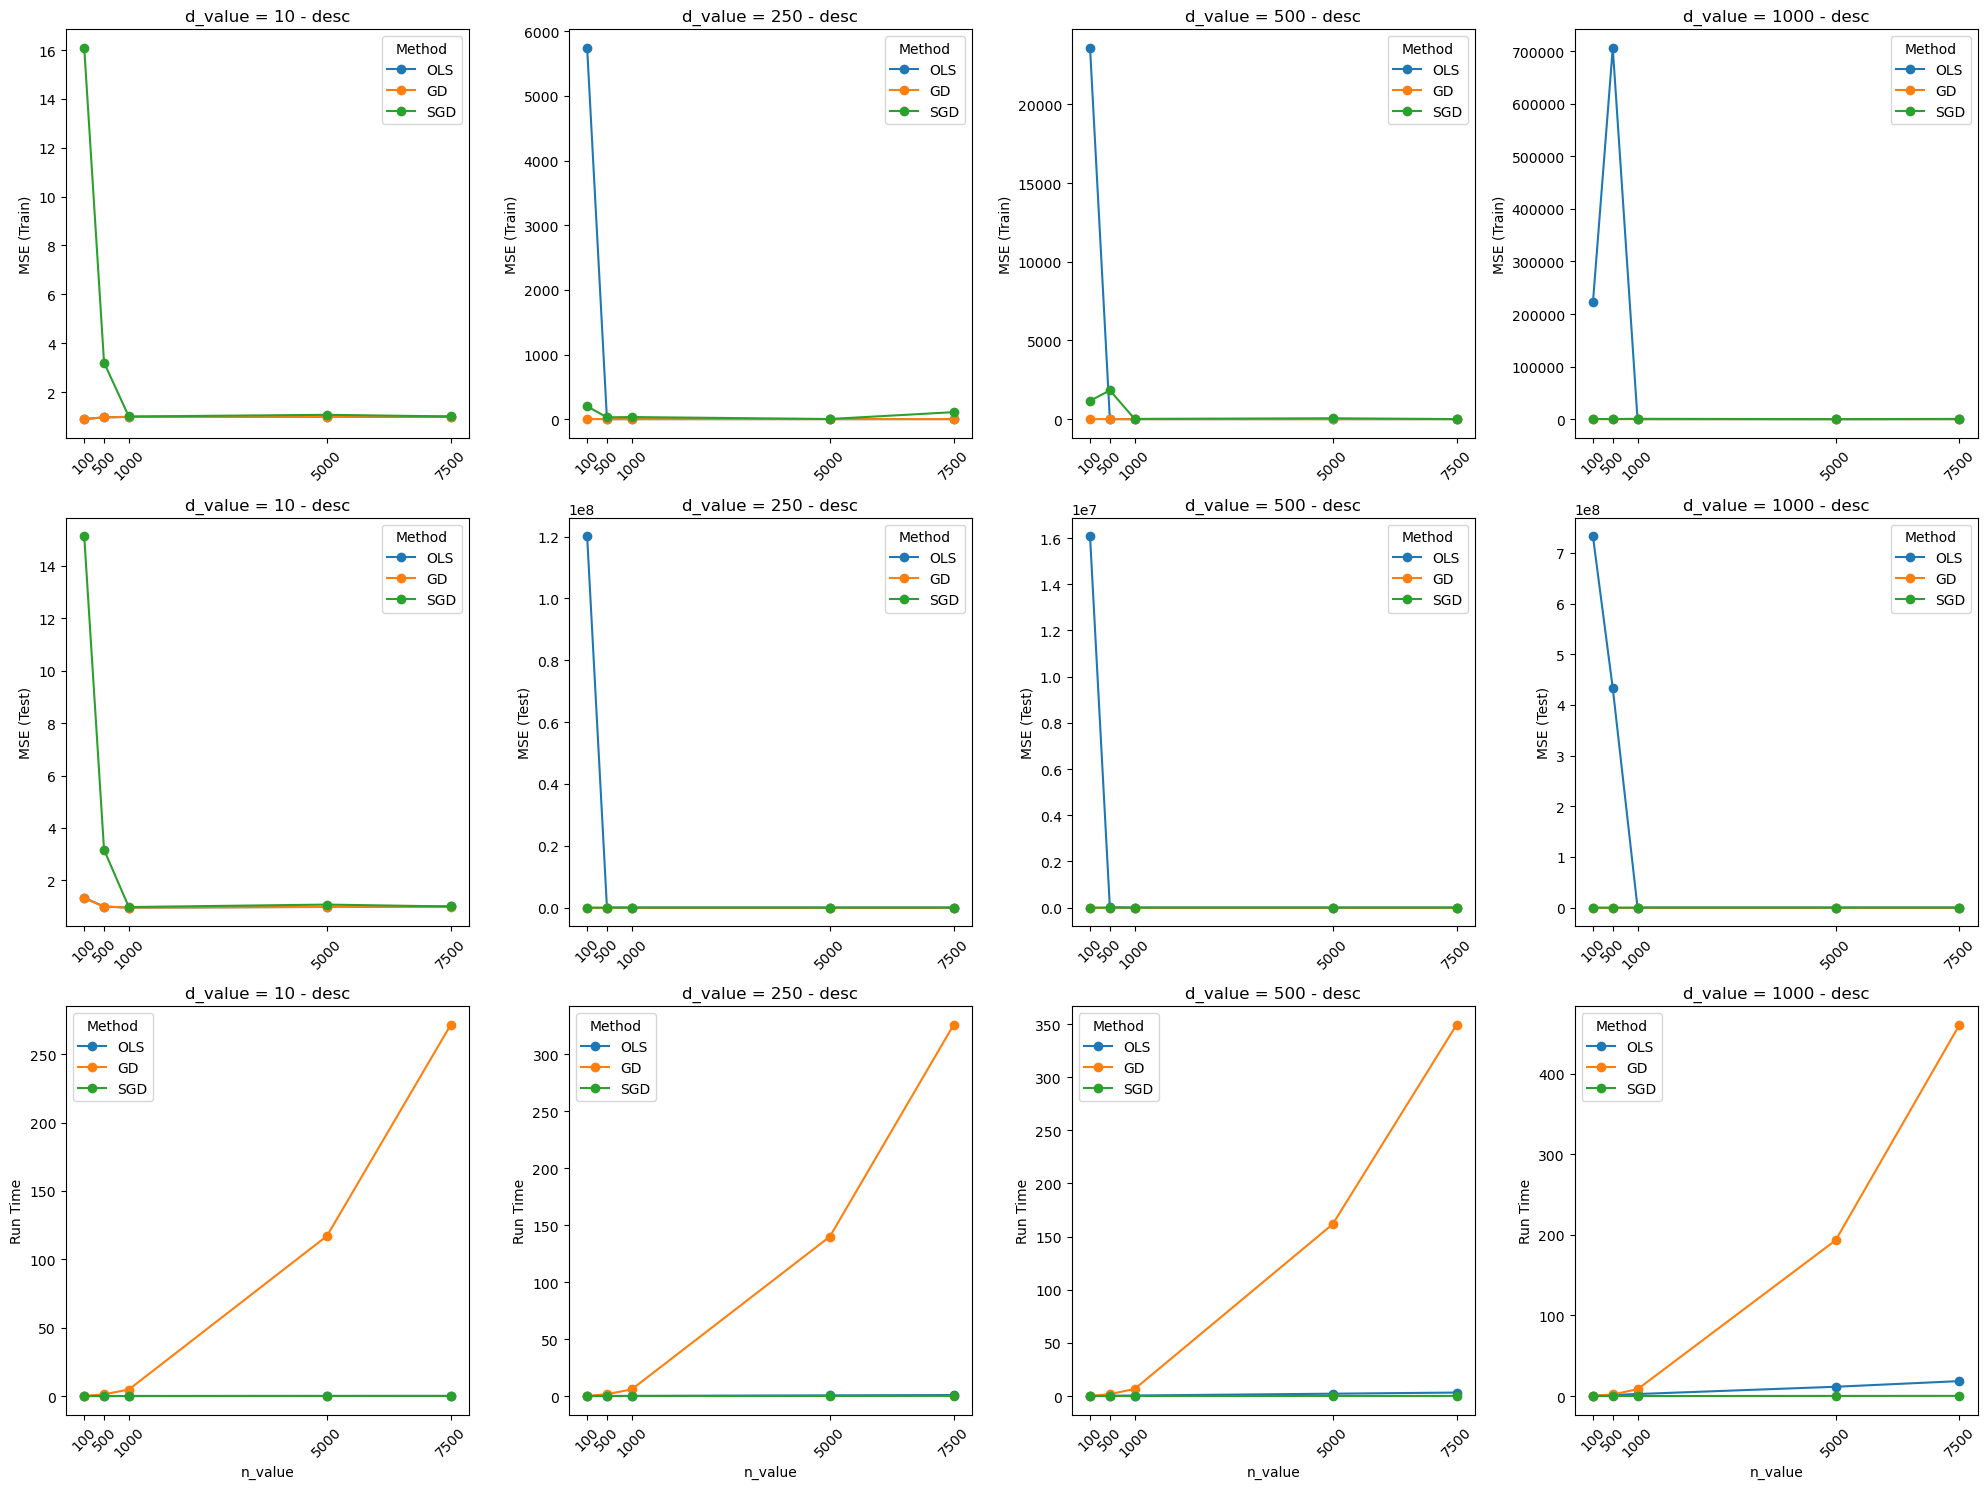

In [ ]:
#plot results

step_size_type = "desc"

df_log_ = df_log[df_log['step_size_type']==step_size_type].copy()
df_log_.reset_index(drop = True, inplace = True)

col_avg_values = ['mse_train','mse_test','run_time']
for col in col_avg_values:
    df_log_[col] = df_log_.groupby(by = ['method','n_value','d_value'])[col].transform('mean')

df_log_.drop_duplicates(subset = ['method','n_value','d_value'], inplace = True)
methods = ['OLS', 'GD', 'SGD']
df = df_log_.copy()

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    for j, d_val in enumerate(d_values):
        ax = axes[i, j]
        for method in methods:
            subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
            ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
        
        ax.set_title(f'd_value = {d_val} - {step_size_type}')
        if i == 0:
            ax.set_ylabel('MSE (Train)')
        elif i == 1:
            ax.set_ylabel('MSE (Test)')
        else:
            ax.set_ylabel('Run Time')
        ax.legend(title='Method')
        ax.set_xticks(subset['n_value'])
        ax.tick_params(axis='x', rotation=45)

for ax in axes[-1, :]:
    ax.set_xlabel('n_value')

plt.tight_layout()
plt.show()

add commentary here